# Мастерская №2 

## Описание проекта
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. 
Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.
Вам предстоит выполнить инженеринг признаков, обучить и оптимизировать модель бинарной классификации, которая предскажет вероятность совершения покупки пользователем в течение 90 дней.

Цель: Предсказать вероятность покупки в течение 90 дней

### Результат проекта
Репозиторий на гитхабе:
1. Тетрадь jupyter notebook с описанием, подготовкой признаков, обучением модели и
тестированием
2. Описание проекта и инструкция по использованию в файле README.md
3. Список зависимостей в файле requirements.txt

### План проекта:
1. Установка библиотек
2. Загрузка данных
3. Предобработка и исследование данных
4. Обучение модели и максимизация метрик
5. Тестирование модели
6. Вывод

### Описание данных:
apparel-purchases история покупок
- Данные о покупках клиентов по дням и по товарам. 
- В каждой записи покупка определенного товара, его цена, количество штук.
- В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например автотовары-аксессуары-освежители), но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам.
- Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. 
- Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']. Как обработать такие случаи – можете предлагать свои варианты решения.


- client_id - идентификатор пользователя
- quantity - количество товаров в заказе
- price цена - товара
- category_ids - вложенные категории, к которым отнсится товар
- date - дата покупки
- message_id - идентификатор сообщения из рассылки

apparel-messages история рекламных рассылок
Рассылки, которые были отправлены клиентам из таблицы покупок.
- bulk_campaign_id - идентификатор рекламной кампании
- client_id - идентификатор пользователя
- message_id - идентификатор сообщений
- event тип - действия
- channel - канал рассылки
- date - дата рассылки
- created_at - точное время создания сообщения


apparel-target_binary
совершит ли клиент покупку в течение следующих 90 дней
- client_id идентификатор пользователя
- target целевой признак

Общая база рассылок огромна, поэтому собрали для вас агрегированную по дням статистику по рассылкам. Если будете создавать на основе этой статистики дополнительные признаки, обратите внимание, что нельзя суммировать по колонкам nunique, потому что это уникальные клиенты в пределах дня, у вас нет данных, повторяются ли они в другие дни

full_campaign_daily_event - Агрегация общей базы рассылок по дням и типам событий
- date - дата
- bulk_campaign_id - идентификатор рассылки
- count_event - общее количество каждого события event количество уникальных client_id в каждом событии
- nunique_event - в именах колонок найдете все типы событий event

full_campaign_daily_event_channel Агрегация по дням с учетом событий и каналов рассылки
- date - дата
- bulk_campaign_id - идентификатор рассылки
- count_event_channel - общее количество каждого события по каналам количество уникальных client_id по событиям и каналам
- nunique_event_channel - в именах колонок есть все типы событий event и каналов рассылки channel

## 1. Установка библиотек

In [17]:
!pip install catboost imbalanced-learn pandas numpy matplotlib seaborn phik -q

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from phik import phik_matrix
import logging
warnings.filterwarnings('ignore')
# Настройка логгирования
logging.basicConfig(filename='feature_optimization.log', level=logging.INFO)

In [18]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


## 2. Загрузка данных

In [19]:
def load_data():
    """Загрузка всех необходимых данных"""
    print("Загрузка данных...")
    df_target = pd.read_csv("/Users/erofeev-as/Desktop/dev/masterskaya_2/STD_M2_purchase_in_90_days/filtered_data/apparel-target_binary.csv")
    df_messages = pd.read_csv("/Users/erofeev-as/Desktop/dev/masterskaya_2/STD_M2_purchase_in_90_days/filtered_data/apparel-messages.csv")
    df_purchases = pd.read_csv("/Users/erofeev-as/Desktop/dev/masterskaya_2/STD_M2_purchase_in_90_days/filtered_data/apparel-purchases.csv")
    df_daily_event_channel = pd.read_csv("/Users/erofeev-as/Desktop/dev/masterskaya_2/STD_M2_purchase_in_90_days/filtered_data/full_campaign_daily_event_channel.csv")
    df_daily_event = pd.read_csv("/Users/erofeev-as/Desktop/dev/masterskaya_2/STD_M2_purchase_in_90_days/filtered_data/full_campaign_daily_event.csv")
    
    print("\nПервичная статистика:")
    print(f"Целевой датафрейм: {df_target.shape[0]} строк, {df_target.shape[1]} столбцов")
    print(f"Сообщения: {df_messages.shape[0]} строк, {df_messages.shape[1]} столбцов")
    print(f"Покупки: {df_purchases.shape[0]} строк, {df_purchases.shape[1]} столбцов")
    
    return df_target, df_messages, df_purchases, df_daily_event_channel, df_daily_event

## 3. Предобработка и исследование данных

In [20]:
def preprocess_data(df_target, df_messages, df_purchases, df_daily_event_channel, df_daily_event):
    """Предобработка и объединение данных"""
    print("\n" + "="*50)
    print("НАЧАЛО ПРЕДОБРАБОТКИ ДАННЫХ")
    print("="*50)
    
    # Преобразование дат
    df_messages['date'] = pd.to_datetime(df_messages['date'])
    df_purchases['date'] = pd.to_datetime(df_purchases['date'])
    df_daily_event_channel['date'] = pd.to_datetime(df_daily_event_channel['date'])
    df_daily_event['date'] = pd.to_datetime(df_daily_event['date'])
    
    # Обработка категорий покупок
    def process_categories(category_ids):
        try:
            categories = eval(category_ids) if isinstance(category_ids, str) else category_ids
            return categories[-3:] if len(categories) >= 3 else categories
        except:
            return []
    
    df_purchases['processed_categories'] = df_purchases['category_ids'].apply(process_categories)
    df_purchases['main_category'] = df_purchases['processed_categories'].apply(lambda x: x[0] if len(x) > 0 else 'unknown')
    df_purchases['sub_category'] = df_purchases['processed_categories'].apply(lambda x: x[1] if len(x) > 1 else 'unknown')
    
    # Агрегация покупок
    purchases_agg = df_purchases.groupby(['client_id', 'date']).agg({
        'quantity': 'sum',
        'price': 'sum',
        'main_category': lambda x: x.mode()[0] if not x.mode().empty else 'unknown',
        'sub_category': lambda x: x.mode()[0] if not x.mode().empty else 'unknown'
    }).reset_index()
    purchases_agg['total_spent'] = purchases_agg['quantity'] * purchases_agg['price']
    
    # Обработка сообщений
    message_events = df_messages.groupby(['client_id', 'date', 'channel'])['event'].value_counts().unstack(fill_value=0).reset_index()
    
    # Объединение данных
    merged = pd.merge(
        purchases_agg,
        message_events,
        on=['client_id', 'date'],
        how='left'
    ).fillna(0)
    
    # Добавление целевой переменной
    merged_with_target = pd.merge(
        merged,
        df_target[['client_id', 'target']],
        on='client_id',
        how='left'
    ).fillna({'target': 0})
    
    # Агрегация статистик рассылок
    campaign_daily_agg = df_daily_event.groupby(['date']).sum().reset_index()
    campaign_daily_channel_agg = df_daily_event_channel.groupby(['date']).sum().reset_index()
    
    # Финальное объединение
    result_df = pd.merge(
        merged_with_target,
        campaign_daily_agg,
        on=['date'],
        how='left'
    )
    
    result_df = pd.merge(
        result_df,
        campaign_daily_channel_agg,
        on=['date'],
        how='left',
        suffixes=('', '_channel')
    ).fillna(0)
    
    # Удаление дубликатов
    initial_rows = len(result_df)
    result_df = result_df.drop_duplicates()
    print(f"Удалено дубликатов: {initial_rows - len(result_df)}")
    
    print("\n" + "="*50)
    print("ЗАВЕРШЕНИЕ ПРЕДОБРАБОТКИ ДАННЫХ")
    print("="*50)
    
    return result_df

In [21]:
def add_time_features(df):
    """Добавление временных признаков"""
    print("\nДобавление временных признаков...")
    df = df.sort_values(['client_id', 'date'])
    
    # Признаки времени
    df['days_since_last_purchase'] = df.groupby('client_id')['date'].diff().dt.days.fillna(0)
    df['purchase_frequency'] = df.groupby('client_id')['date'].transform(
        lambda x: 1 / x.diff().dt.days.mean() if x.diff().dt.days.mean() > 0 else 0
    )
    
    # Календарные признаки
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['date'].dt.dayofweek >= 5
    
    print(f"Добавлено 6 временных признаков")
    return df

In [22]:
def add_rfm_features(df):
    """Добавление RFM-метрик"""
    print("\nДобавление RFM-метрик...")
    rfm = df.groupby('client_id').agg({
        'date': lambda x: (df['date'].max() - x.max()).days,
        'price': ['count', 'mean']
    })
    rfm.columns = ['recency', 'frequency', 'monetary']
    return pd.merge(df, rfm, on='client_id', how='left')

In [23]:
def add_behavior_features(df):
    """Добавление поведенческих признаков"""
    print("\nДобавление поведенческих признаков...")
    # Среднее время между покупками
    df['avg_purchase_interval'] = df.groupby('client_id')['date'].transform(
        lambda x: x.diff().dt.days.mean() if len(x) > 1 else 0
    )
    
    # Активность в разных периодах
    for days in [30, 90, 180]:
        df[f'purchases_last_{days}_days'] = df.groupby('client_id')['date'].transform(
            lambda x: ((x.max() - x) <= timedelta(days=days)).sum()
        )
    
    print(f"Добавлено 4 поведенческих признака")
    return df

In [24]:
def prepare_final_data(result_df):
    """Подготовка финального датасета"""
    print("\nПодготовка финального датасета...")
    result_df = add_rfm_features(result_df)
    result_df = add_behavior_features(result_df)
    
    # Преобразование категориальных признаков
    cat_cols = result_df.select_dtypes(include=['object']).columns.tolist()
    for col in cat_cols:
        result_df[col] = result_df[col].astype('category').cat.codes
    
    # Удаление ненужных столбцов
    cols_to_drop = ['client_id', 'date', 'processed_categories', 'message_id']
    result_df = result_df.drop(columns=[col for col in cols_to_drop if col in result_df.columns])
    
    
    print(f"Итоговое количество признаков: {len(result_df.columns)}")
    return result_df

In [25]:
def eda(result_df):
    """Исследовательский анализ данных"""
    print("\n" + "="*50)
    print("ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ")
    print("="*50)
    
    # 1. Анализ целевой переменной
    print("\n1. Распределение целевой переменной:")
    target_dist = result_df['target'].value_counts(normalize=True)
    print(target_dist)
    
    plt.figure(figsize=(8, 5))
    sns.countplot(x='target', data=result_df)
    plt.title(f'Распределение целевой переменной (1: {target_dist[1]:.2%}, 0: {target_dist[0]:.2%})')
    plt.show()
    
    # 2. Первоначальный анализ основных числовых признаков
    print("\n2. Первоначальный анализ основных числовых признаков:")
    # Исключаем client_id и bulk_campaign_id из анализа
    numeric_cols = result_df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in ['client_id', 'bulk_campaign_id']]
    basic_features = ['quantity', 'price', 'total_spent', 'target']
    basic_features = [col for col in basic_features if col in numeric_cols]
    
    print(result_df[basic_features].describe().T)
    
    # 3. Корреляционный анализ основных признаков
    print("\n3. Корреляционный анализ основных признаков (PhiK):")
    basic_phik = result_df[basic_features].phik_matrix()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(basic_phik, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title('Матрица корреляций PhiK (основные признаки)')
    plt.show()
    
    # 4. Добавление новых признаков
    print("\n4. Добавление новых признаков...")
    result_df = add_time_features(result_df.copy())
    result_df = add_rfm_features(result_df.copy())
    result_df = add_behavior_features(result_df.copy())
    
    # 5. Анализ после добавления признаков
    print("\n5. Описательная статистика после добавления признаков:")
    numeric_cols = result_df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in ['client_id', 'bulk_campaign_id']]
    display(result_df[numeric_cols].describe().T)
    
    # 6. Полный корреляционный анализ
    print("\n6. Полный корреляционный анализ (PhiK):")
    full_phik = result_df[numeric_cols].phik_matrix()
    
    # Анализ корреляций с целевой переменной
    if 'target' in numeric_cols:
        target_corr = full_phik[['target']].sort_values('target', key=abs, ascending=False)
        
        print("\nТоп-15 признаков по корреляции с целевой переменной:")
        print(target_corr.head(15))
        
        plt.figure(figsize=(8, 10))
        sns.heatmap(target_corr.head(15), annot=True, fmt=".2f", cmap='coolwarm', center=0)
        plt.title('Топ-15 корреляций с целевой переменной (PhiK)')
        plt.show()
    
    # Анализ межпризнаковых корреляций
    print("\n7. Анализ межпризнаковых корреляций (|PhiK| >= 0.7):")
    high_corr = full_phik[abs(full_phik) >= 0.7].stack().reset_index()
    high_corr = high_corr[high_corr['level_0'] != high_corr['level_1']]
    high_corr = high_corr.sort_values(0, ascending=False, key=abs)
    
    if not high_corr.empty:
        print("\nСамые сильные корреляции между признаками:")
        print(high_corr.head(15))
        
        # Визуализация топ-10 межпризнаковых корреляций
        high_corr_pivot = high_corr.pivot(index='level_0', columns='level_1', values=0).head(10)
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(high_corr_pivot, annot=True, fmt=".2f", cmap='coolwarm', center=0)
        plt.title('Топ-10 сильных межпризнаковых корреляций (|PhiK| >= 0.7)')
        plt.show()
    else:
        print("Нет сильных корреляций между признаками (|PhiK| < 0.7)")
    
    print("\n" + "="*50)
    print("ЗАВЕРШЕНИЕ ИССЛЕДОВАТЕЛЬСКОГО АНАЛИЗА ДАННЫХ")
    print("="*50)
    
    return result_df

## 4. Обучение модели

In [26]:
def optimize_features(result_df, threshold=0.01):
    """
    Оптимизация признакового пространства:
    - Анализ важности признаков
    - Удаление низковариативных и сильно коррелирующих признаков
    """
    logging.info("\n=== Начало оптимизации признаков ===")
    df = prepare_final_data(result_df.copy())
    
    X = df.drop(columns=['target'])
    y = df['target']
    
    # Обучаем быструю модель для оценки важности
    model = CatBoostClassifier(
        iterations=100,
        random_seed=1618,
        verbose=0
    )
    model.fit(X, y)
    
    # Получаем важность признаков
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Удаляем незначимые признаки
    insignificant_features = feature_importance[feature_importance['importance'] < threshold]['feature'].tolist()
    print(f"\nУдаляем незначимые признаки: {insignificant_features}")
    df = df.drop(columns=insignificant_features)
    
    # Удаляем сильно коррелирующие признаки (PhiK > 0.9)
    phik_matrix = df.phik_matrix()
    high_corr = set()
    for i in range(len(phik_matrix.columns)):
        for j in range(i):
            if abs(phik_matrix.iloc[i, j]) > 0.9:
                colname = phik_matrix.columns[i]
                high_corr.add(colname)
    print(f"\nУдаляем сильно коррелирующие признаки: {high_corr}")
    df = df.drop(columns=high_corr)
    
    logging.info(f"Удалены признаки: {insignificant_features + list(high_corr)}")
    logging.info(f"Итоговые признаки: {df.columns.tolist()}")
    
    return df

In [27]:
def time_series_cross_val(X, y, dates, model_params, n_splits=3):
    """Временная кросс-валидация"""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    metrics = []
    models = []
    feature_importances = []
    
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        train_dates = dates.iloc[train_idx]
        test_dates = dates.iloc[test_idx]
        
        print(f"\nFold {fold + 1}:")
        print(f"Train period: {train_dates.min().date()} - {train_dates.max().date()}")
        print(f"Test period: {test_dates.min().date()} - {test_dates.max().date()}")
        print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
        
        # Применяем SMOTE
        smote = SMOTE(random_state=1618)
        X_train_res, y_train_res = smote.fit_resample(X_train[numeric_cols], y_train)
        X_train_res = pd.DataFrame(X_train_res, columns=numeric_cols)
        
        # Обучаем модель
        model = CatBoostClassifier(**model_params)
        model.fit(
            X_train_res, y_train_res,
            eval_set=(X_test[numeric_cols], y_test),
            use_best_model=True,
            verbose=50
        )
        
        y_pred_proba = model.predict_proba(X_test[numeric_cols])[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        metrics.append(roc_auc)
        models.append(model)
        feature_importances.append(model.feature_importances_)
        
        print(f"\nFold {fold + 1} - ROC-AUC: {roc_auc:.4f}")
        print(classification_report(y_test, model.predict(X_test[numeric_cols])))
        
        plot_roc_curve(y_test, y_pred_proba, title=f'Fold {fold + 1} - ROC Curve')
        plot_pr_curve(y_test, y_pred_proba, title=f'Fold {fold + 1} - Precision-Recall Curve')
    
    print("\nAverage ROC-AUC across all folds:", np.mean(metrics))
    
    # Визуализация важности признаков
    feature_imp_df = pd.DataFrame({
        'feature': numeric_cols,
        'importance': np.mean(feature_importances, axis=0)
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_imp_df.head(20))
    plt.title('Average Feature Importance Across Folds')
    plt.tight_layout()
    plt.show()
    
    return models, metrics

In [28]:
def train_final_model(result_df):
    """Обучение финальной модели с оптимизацией признаков"""
    print("\nОптимизация признакового пространства...")
    df = optimize_features(result_df)
    
    X = df.drop(columns=['target'])
    y = df['target']
    dates = result_df.loc[X.index, 'date']
    
    model_params = {
        'iterations': 1000,
        'depth': 6,
        'learning_rate': 0.05,
        'l2_leaf_reg': 3,
        'scale_pos_weight': 10,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': 1618,
        'early_stopping_rounds': 50,
        'verbose': False
    }
    
    print("\nИтоговое количество признаков:", X.shape[1])
    print("Список признаков:", list(X.columns))
    
    print("Starting Time Series Cross-Validation...")
    models, metrics = time_series_cross_val(X, y, dates, model_params, n_splits=3)
    
    best_model_idx = np.argmax(metrics)
    best_model = models[best_model_idx]
    print(f"\nBest model from fold {best_model_idx + 1} with ROC-AUC: {metrics[best_model_idx]:.4f}")
    
    # Визуализация важности признаков
    plt.figure(figsize=(12, 8))
    feature_imp = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(20)
    
    sns.barplot(x='importance', y='feature', data=feature_imp)
    plt.title('Top 20 Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return best_model

In [29]:
def plot_roc_curve(y_true, y_proba, title='ROC Curve'):
    """Визуализация ROC-кривой"""
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [30]:
def plot_pr_curve(y_true, y_proba, title='Precision-Recall Curve'):
    """Визуализация Precision-Recall кривой"""
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="upper right")
    plt.show()

## 5. Тестирование модели

In [31]:

def test_model(model, result_df):
    """Тестирование модели на отложенной выборке"""
    print("\nТестирование модели на отложенной выборке...")
    
    df = prepare_final_data(result_df)
    
    try:
        expected_features = model.feature_names_
        X = df[expected_features]
    except:
        X = df.drop(columns=['target'])
    
    y = df['target']
    dates = result_df.loc[X.index, 'date']
    
    # Выбираем последние 20% данных для теста
    test_size = int(len(X) * 0.2)
    X_test = X.iloc[-test_size:]
    y_test = y.iloc[-test_size:]
    dates_test = dates.iloc[-test_size:]
    
    print(f"\nТестовая выборка: {dates_test.min().date()} - {dates_test.max().date()}")
    print(f"Размер тестовой выборки: {len(X_test)}")
    
    # Прогнозирование
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Оценка качества
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC-AUC на тестовой выборке: {roc_auc:.4f}")
    print("\nОтчет по классификации:")
    print(classification_report(y_test, y_pred))
    
    # Визуализация
    plot_roc_curve(y_test, y_pred_proba, title='ROC Curve (Test Set)')
    plot_pr_curve(y_test, y_pred_proba, title='Precision-Recall Curve (Test Set)')
    
    return {
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'roc_auc': roc_auc
    }

## Пайплайн и результаты

Загрузка данных...

Первичная статистика:
Целевой датафрейм: 49849 строк, 2 столбцов
Сообщения: 12739798 строк, 7 столбцов
Покупки: 202208 строк, 6 столбцов

НАЧАЛО ПРЕДОБРАБОТКИ ДАННЫХ
Удалено дубликатов: 0

ЗАВЕРШЕНИЕ ПРЕДОБРАБОТКИ ДАННЫХ

ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

1. Распределение целевой переменной:
target
0    0.971993
1    0.028007
Name: proportion, dtype: float64


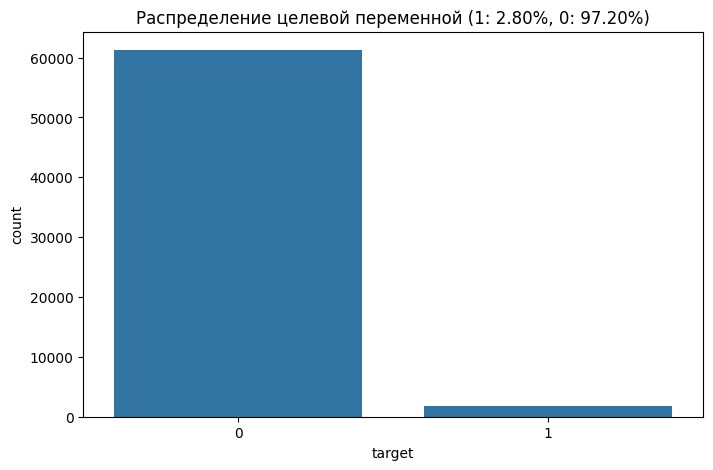


2. Первоначальный анализ основных числовых признаков:
               count          mean            std  min     25%     50%  \
quantity     63021.0      3.395900       4.062262  1.0     1.0     2.0   
price        63021.0   4015.953603    5732.362502  1.0  1398.0  2499.0   
total_spent  63021.0  23963.101046  144881.319380  1.0  1999.0  5499.0   
target       63021.0      0.028007       0.164993  0.0     0.0     0.0   

                 75%         max  
quantity         4.0       216.0  
price         4858.0    387583.0  
total_spent  16232.0  14340571.0  
target           0.0         1.0  

3. Корреляционный анализ основных признаков (PhiK):
interval columns not set, guessing: ['quantity', 'price', 'total_spent', 'target']


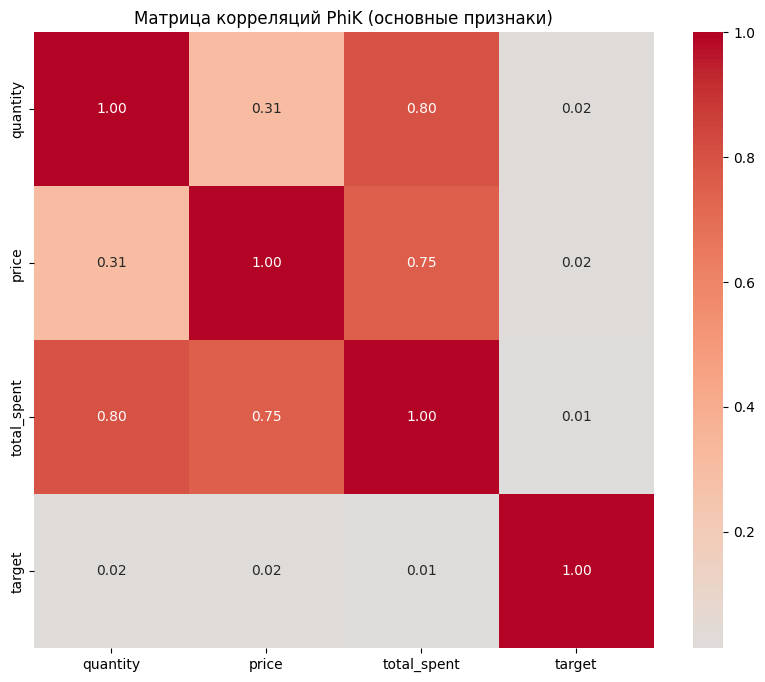


4. Добавление новых признаков...

Добавление временных признаков...
Добавлено 6 временных признаков

Добавление RFM-метрик...

Добавление поведенческих признаков...
Добавлено 4 поведенческих признака

5. Описательная статистика после добавления признаков:


,count,mean,std,min,25%,50%,75%,max
quantity,63021.0,3.395900,4.062262,1.0,1.0,2.0,4.0,216.0
price,63021.0,4015.953603,5732.362502,1.0,1398.0,2499.0,4858.0,387583.0
total_spent,63021.0,23963.101046,144881.319380,1.0,1999.0,5499.0,16232.0,14340571.0
click,63021.0,0.971613,1.399768,0.0,0.0,1.0,1.0,45.0
close,63021.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
monetary,63021.0,4015.953603,5345.913423,1.0,1499.0,2659.0,4887.2,387583.0
avg_purchase_interval,63021.0,28.462775,72.146317,0.0,0.0,0.0,2.0,619.0
purchases_last_30_days,63021.0,1.226893,0.559909,1.0,1.0,1.0,1.0,10.0
purchases_last_90_days,63021.0,1.323067,0.761398,1.0,1.0,1.0,1.0,17.0



6. Полный корреляционный анализ (PhiK):
interval columns not set, guessing: ['quantity', 'price', 'total_spent', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe', 'target', 'count_click', 'count_complain', 'count_hard_bounce', 'count_open', 'count_purchase', 'count_send', 'count_soft_bounce', 'count_subscribe', 'count_unsubscribe', 'nunique_click', 'nunique_complain', 'nunique_hard_bounce', 'nunique_open', 'nunique_purchase', 'nunique_send', 'nunique_soft_bounce', 'nunique_subscribe', 'nunique_unsubscribe', 'count_hbq_spam', 'nunique_hbq_spam', 'count_close', 'nunique_close', 'bulk_campaign_id_channel', 'count_click_email', 'count_click_mobile_push', 'count_open_email', 'count_open_mobile_push', 'count_purchase_email', 'count_purchase_mobile_push', 'count_soft_bounce_email', 'count_subscribe_email', 'count_unsubscribe_email', 'nunique_click_email', 'nunique_click_mobile_push', 'nunique_open_email', 'nunique_

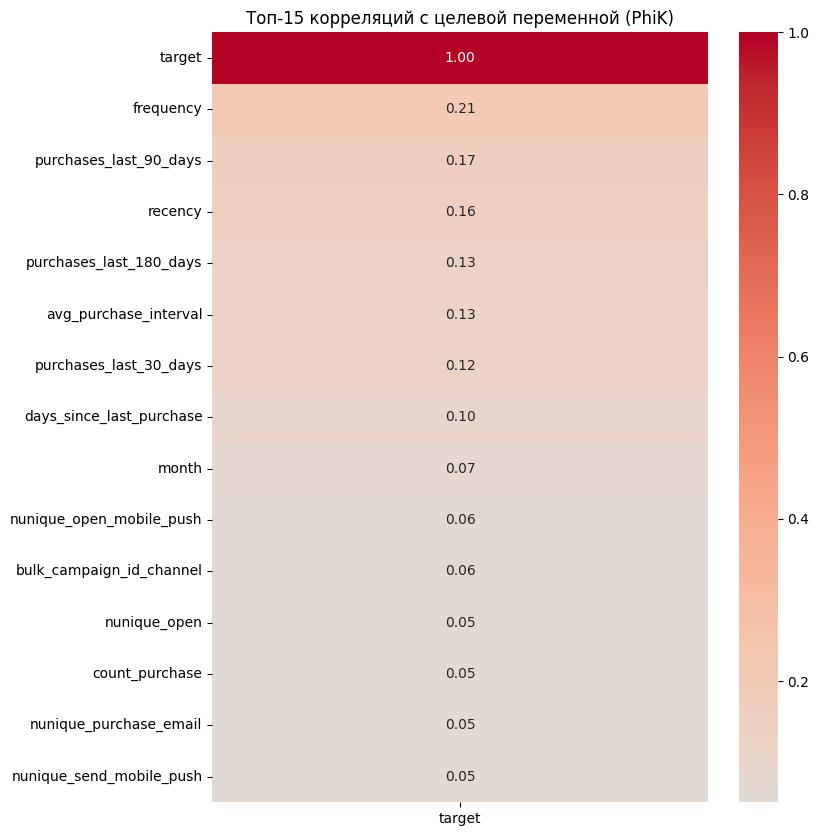


7. Анализ межпризнаковых корреляций (|PhiK| >= 0.7):

Самые сильные корреляции между признаками:
                           level_0                          level_1    0
173              count_unsubscribe          count_close_mobile_push  1.0
351               nunique_hbq_spam           nunique_hbq_spam_email  1.0
779               count_send_email               nunique_send_email  1.0
360                  nunique_close                count_unsubscribe  1.0
671      nunique_unsubscribe_email              nunique_unsubscribe  1.0
356                    count_close          count_unsubscribe_email  1.0
315              nunique_subscribe          nunique_subscribe_email  1.0
860      nunique_close_mobile_push          count_unsubscribe_email  1.0
856      nunique_close_mobile_push                count_unsubscribe  1.0
852        count_close_mobile_push          count_unsubscribe_email  1.0
644        nunique_subscribe_email                nunique_subscribe  1.0
352                    cou

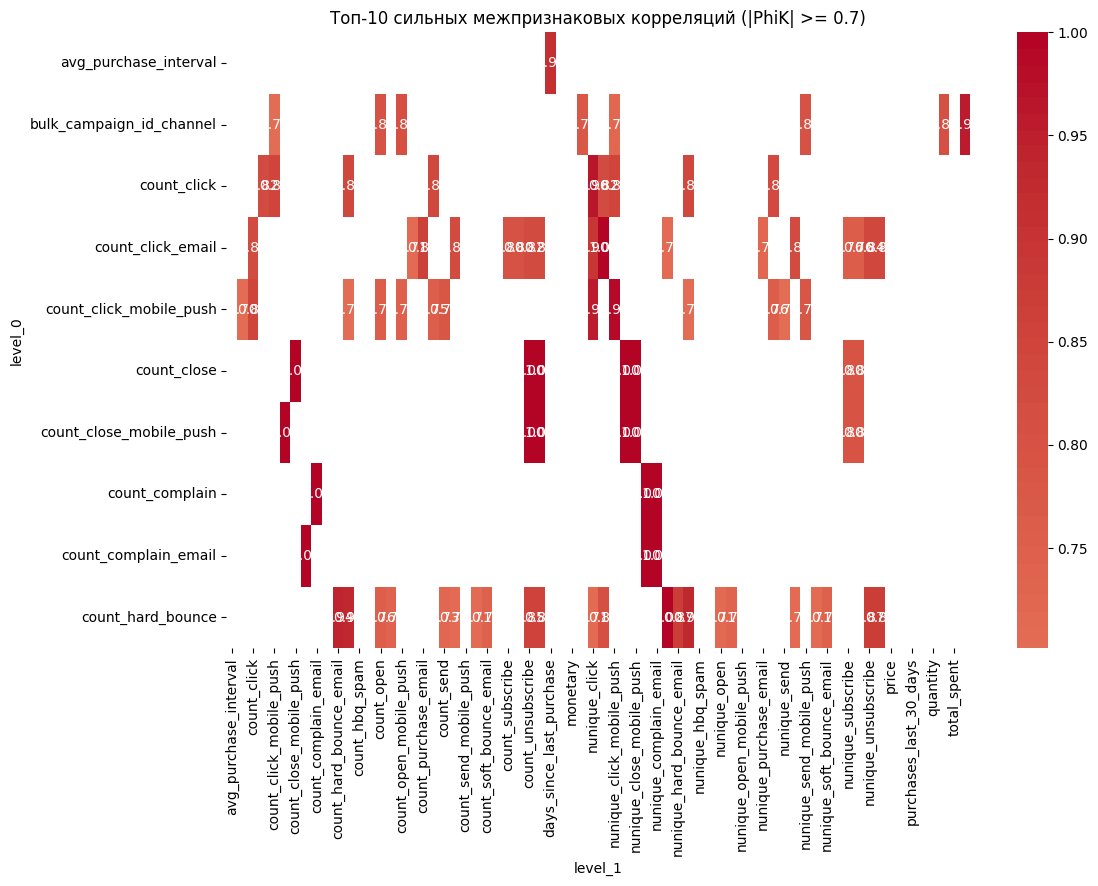


ЗАВЕРШЕНИЕ ИССЛЕДОВАТЕЛЬСКОГО АНАЛИЗА ДАННЫХ

Оптимизация признакового пространства...

Подготовка финального датасета...

Добавление RFM-метрик...

Добавление поведенческих признаков...
Добавлено 4 поведенческих признака
Итоговое количество признаков: 92

Удаляем незначимые признаки: ['hard_bounce', 'subscribe', 'unsubscribe', 'close', 'soft_bounce', 'complain', 'nunique_hbq_spam', 'is_weekend', 'count_open', 'hbq_spam', 'nunique_close_mobile_push', 'count_close_mobile_push', 'count_close', 'count_send_mobile_push', 'nunique_soft_bounce_email', 'nunique_close', 'count_hbq_spam_email']
interval columns not set, guessing: ['quantity', 'price', 'main_category', 'sub_category', 'total_spent', 'channel', 'click', 'open', 'purchase', 'send', 'target', 'bulk_campaign_id', 'count_click', 'count_complain', 'count_hard_bounce', 'count_purchase', 'count_send', 'count_soft_bounce', 'count_subscribe', 'count_unsubscribe', 'nunique_click', 'nunique_complain', 'nunique_hard_bounce', 'nunique_open',

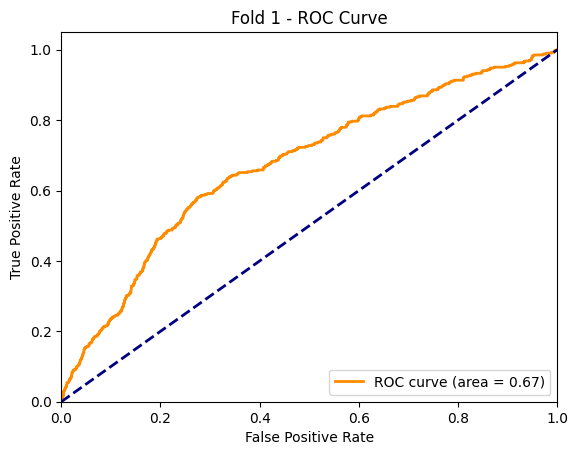

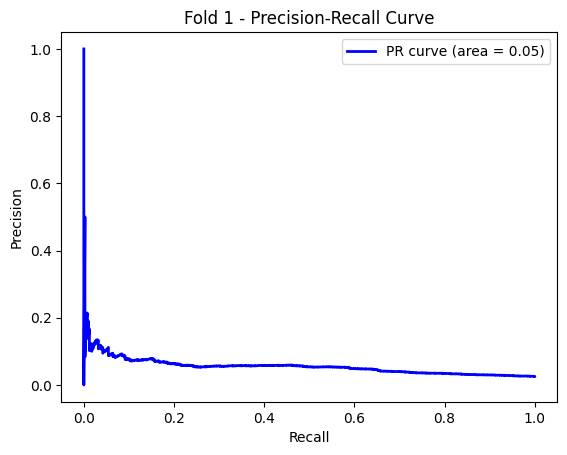


Fold 2:
Train period: 2022-05-16 - 2024-02-16
Test period: 2022-05-16 - 2024-02-16
Train size: 31511, Test size: 15755
0:	test: 0.7073319	best: 0.7073319 (0)	total: 11.1ms	remaining: 11.1s
50:	test: 0.7281379	best: 0.7338224 (20)	total: 456ms	remaining: 8.48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.733822415
bestIteration = 20

Shrink model to first 21 iterations.

Fold 2 - ROC-AUC: 0.7338
              precision    recall  f1-score   support

           0       0.99      0.16      0.27     15206
           1       0.04      0.95      0.08       549

    accuracy                           0.19     15755
   macro avg       0.51      0.55      0.17     15755
weighted avg       0.96      0.19      0.27     15755



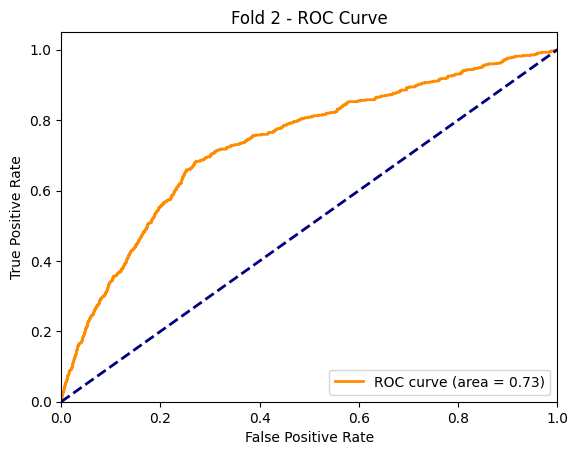

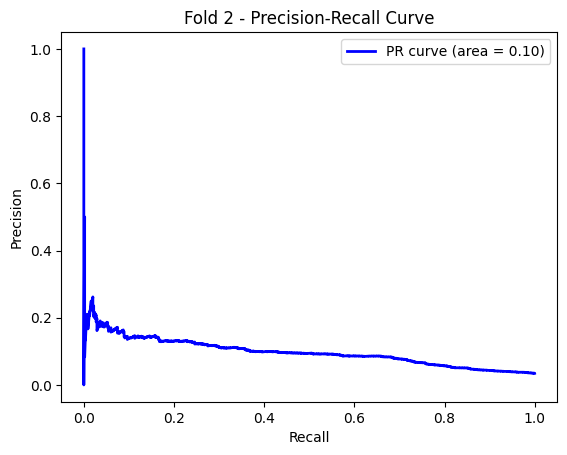


Fold 3:
Train period: 2022-05-16 - 2024-02-16
Test period: 2022-05-16 - 2024-02-16
Train size: 47266, Test size: 15755
0:	test: 0.6869231	best: 0.6869231 (0)	total: 13.9ms	remaining: 13.9s
50:	test: 0.7411350	best: 0.7442551 (37)	total: 596ms	remaining: 11.1s
100:	test: 0.7456313	best: 0.7456420 (99)	total: 1.15s	remaining: 10.3s
150:	test: 0.7464595	best: 0.7464595 (150)	total: 1.7s	remaining: 9.54s
200:	test: 0.7442731	best: 0.7467996 (154)	total: 2.24s	remaining: 8.91s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7467995561
bestIteration = 154

Shrink model to first 155 iterations.

Fold 3 - ROC-AUC: 0.7468
              precision    recall  f1-score   support

           0       0.99      0.75      0.85     15410
           1       0.06      0.66      0.10       345

    accuracy                           0.75     15755
   macro avg       0.52      0.71      0.48     15755
weighted avg       0.97      0.75      0.84     15755



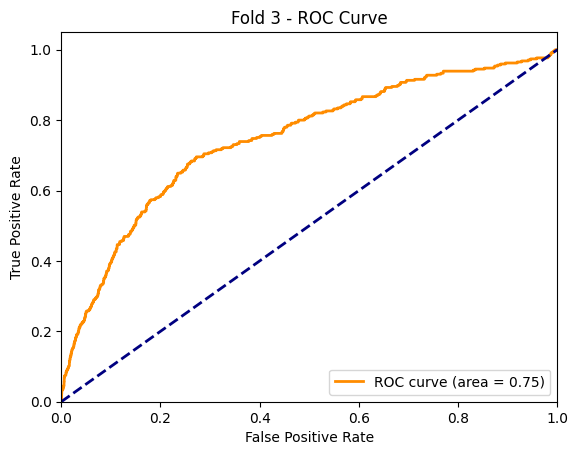

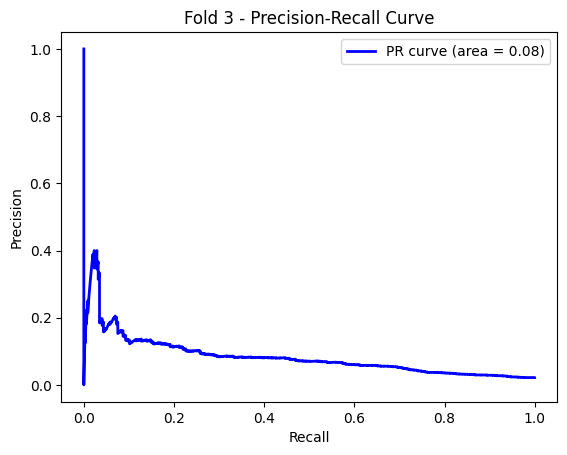


Average ROC-AUC across all folds: 0.7182519131006714


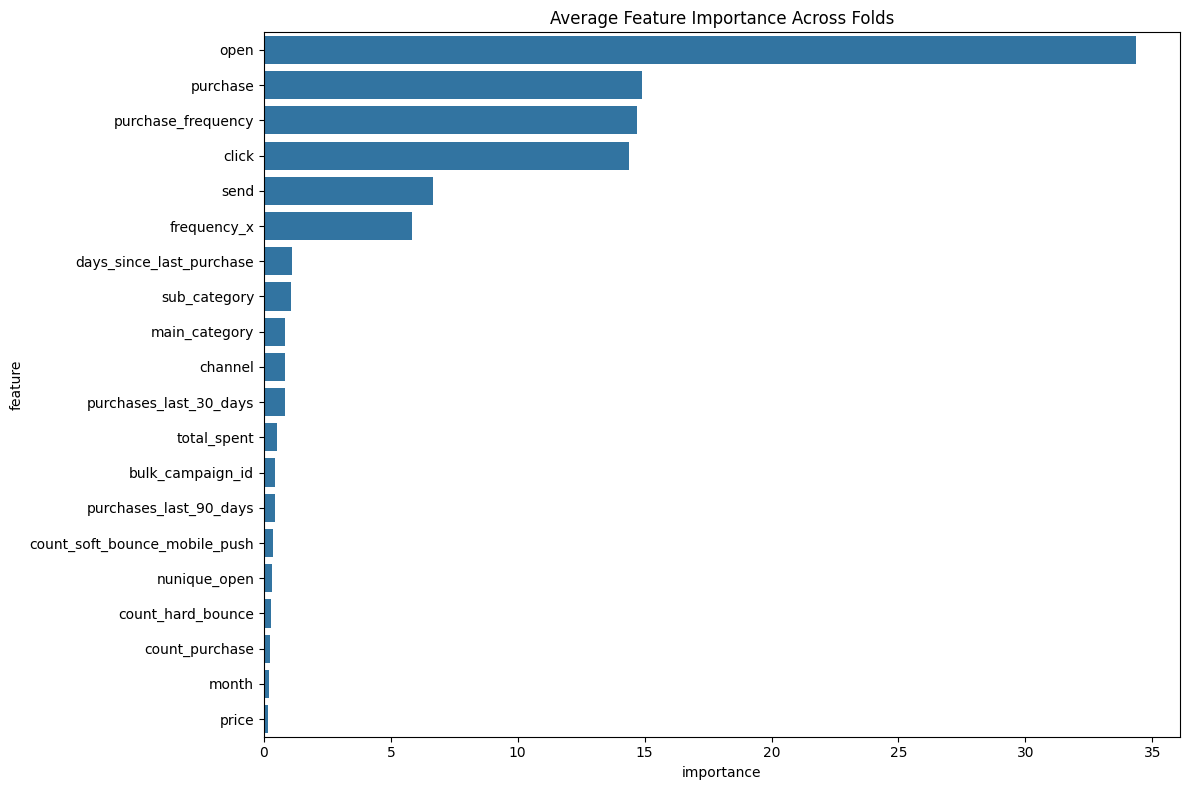


Best model from fold 3 with ROC-AUC: 0.7468


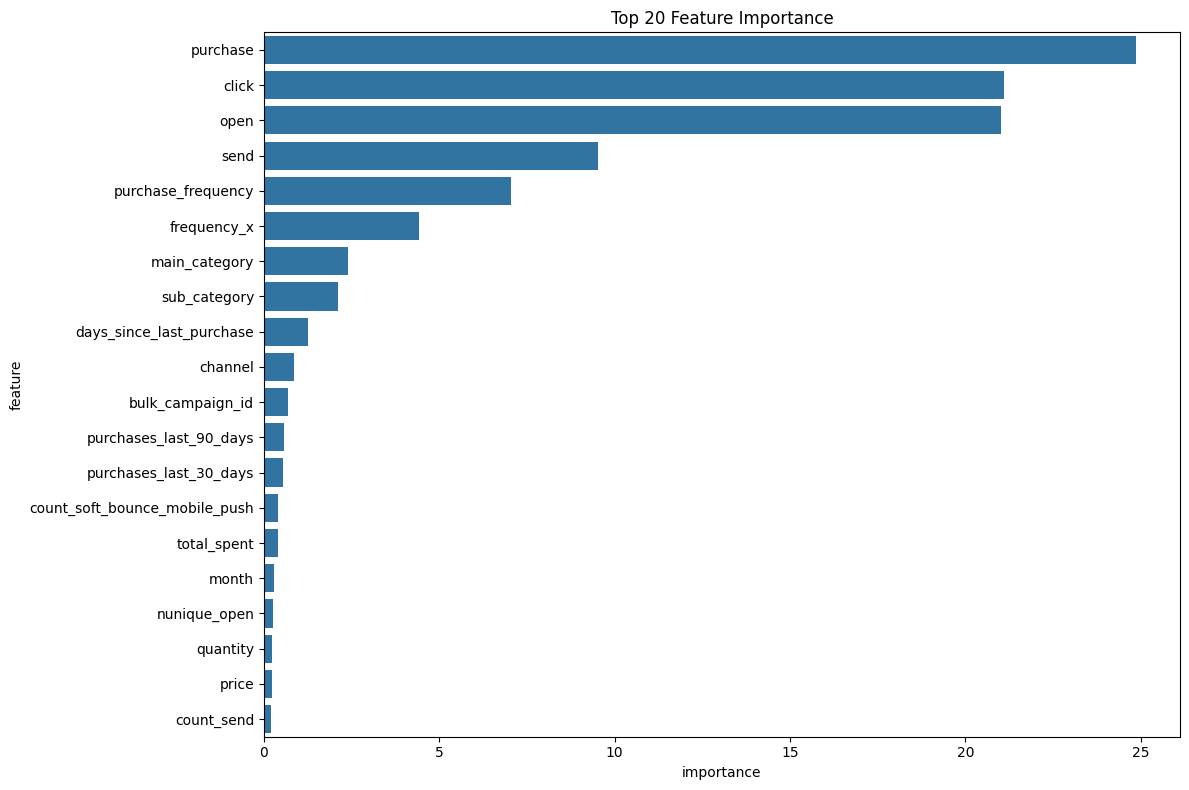


Тестирование модели на отложенной выборке...

Подготовка финального датасета...

Добавление RFM-метрик...

Добавление поведенческих признаков...
Добавлено 4 поведенческих признака
Итоговое количество признаков: 92

Тестовая выборка: 2022-05-16 - 2024-02-16
Размер тестовой выборки: 12604

ROC-AUC на тестовой выборке: 0.7636

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     12315
           1       0.06      0.67      0.11       289

    accuracy                           0.76     12604
   macro avg       0.53      0.71      0.49     12604
weighted avg       0.97      0.76      0.84     12604



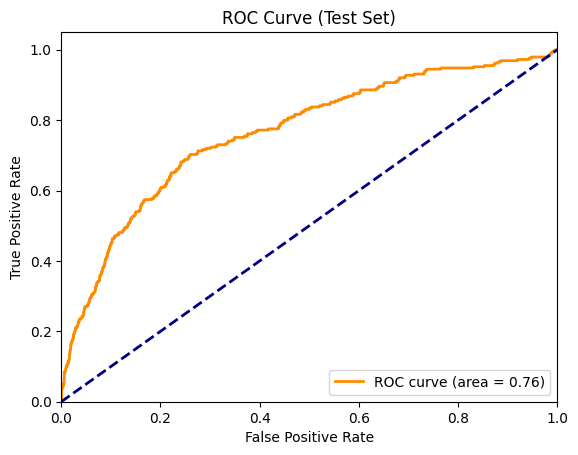

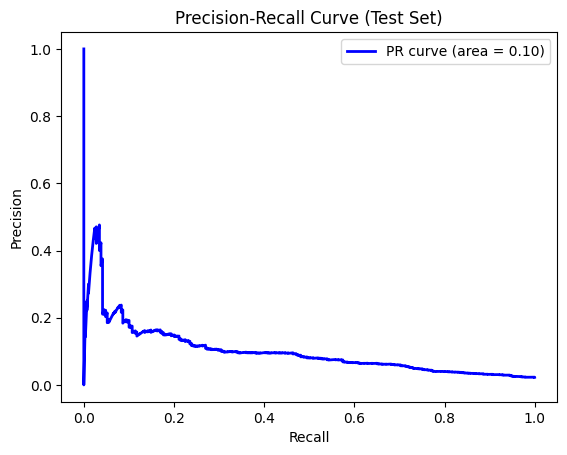


Модель сохранена как 'final_catboost_model.cbm'


In [32]:
def main():
    """Основной пайплайн"""
    # 1. Загрузка данных
    df_target, df_messages, df_purchases, df_daily_event_channel, df_daily_event = load_data()
    
    # 2. Предобработка данных
    result_df = preprocess_data(df_target, df_messages, df_purchases, 
                              df_daily_event_channel, df_daily_event)
    
    # 3. Расширенный анализ данных
    result_df = eda(result_df)
    
    # 4. Обучение модели
    final_model = train_final_model(result_df)
    
    # 5. Тестирование модели
    test_results = test_model(final_model, result_df)
    
    # 6. Сохранение модели
    final_model.save_model('final_catboost_model.cbm')
    print("\nМодель сохранена как 'final_catboost_model.cbm'")

if __name__ == "__main__":
    main()

## 6. Вывод

### В ходе работы были выполнены следующие этапы:

1. **Предобработка и исследование данных**:
   - Распределение целевой переменной показало сильный дисбаланс классов: только 2.8% пользователей совершили покупку в течение 90 дней.
   - Признаки, `frequency`, `purchases_last_90_days`, `recency`, имеют наибольшую корреляцию с целевой переменной.
   - Были загружены и проанализированы данные о покупках, рекламных рассылках и целевой переменной.
   - Проведена предобработка данных, включая обработку категорий, агрегацию покупок и объединение таблиц.
   - Добавлены временные, RFM- и поведенческие признаки для улучшения предсказательной способности модели.
      - Временные признаки: 
         - `days_since_last_purchase`**: количество дней с момента последней покупки.
         - `purchase_frequency`: средняя частота покупок (обратная величина к среднему интервалу между покупками).
         - `year`, `month`, `day_of_week`: компоненты даты для учета сезонности.
         - `is_weekend`: флаг, указывающий, была ли покупка совершена в выходные.
      - RFM-метрики для анализа клиентской активности:
         - `recency` (давность). Показывает, когда клиент совершил последнюю покупку. Этот параметр помогает выделить новых клиентов, а также отслеживать время, прошедшее с момента последней покупки. 
         - `frequencн` (частота). Отражает регулярность покупок. Помогает определить постоянных клиентов, которые верны бренду и, скорее всего, продолжат покупать.
         - `monetary` (деньги). Указывает на общую сумму, которую клиент потратил. Чем выше значение, тем больше средств клиент оставил у компании.
      - Поведенческие признаки, которые отражают активность пользователей в разные периоды:
         - `avg_purchase_interval`: средний интервал между покупками.
         - `purchases_last_30_days`, `purchases_last_90_days`, `purchases_last_180_days` - количество покупок за последние 30, 90 и 180 дней соответственно.
   - Использованны признаки из рекламных рассылок:
      - `click`, `open`, `send`, `purchase`: количество соответствующих событий (клики, открытия, отправки, покупки).
      - `count_click`, `count_open`, `count_send`, `count_purchase`: агрегированные статистики по событиям.
      - `nunique_open`, `nunique_click`: количество уникальных событий открытия/клика.
      - `bulk_campaign_id_channel`: идентификатор рекламной кампании с учетом канала.
   - Категории преобразованы в категориальные признаки:
      - `main_category`, `sub_category`: основная и подкатегория товара (извлечены из `category_ids`).
   - Финансовые признаки:
      - `total_spent`: общая сумма, потраченная пользователем.
      - `price`, `quantity`: цена и количество товаров в заказе.

3. **Обучение модели**:
   - Использована модель CatBoostClassifier с учетом дисбаланса классов (параметр `scale_pos_weight=10`).
   - Проведена временная кросс-валидация, которая показала устойчивость модели на разных временных интервалах.
   - Среднее значение ROC-AUC на кросс-валидации составило 0.718 (Fold 1: 0.674, Fold 2: 0.734, Fold 3: 0.747).

4. **Тестирование модели**:
   - На отложенной выборке модель достигла ROC-AUC 0.764, что свидетельствует о её хорошей обобщающей способности.
   - Precision для класса 1 (покупка) составил 0.06, recall — 0.67, что указывает на способность модели выявлять потенциальных покупателей, но с низкой точностью.

5. **Важные признаки**:
   - Наибольшую важность для модели имеют признаки, связанные с активностью пользователей: `purchase`, `click`, `open`, `send`, `purchase_frequency`, `frequency_x`, `main_category`, `sub_category`, `days_since_last_purchase`.

**Итог**: Модель достигла приемлемого качества (ROC-AUC 0.764) и готова к использованию для прогнозирования покупок в интернет-магазине.